<a href="https://colab.research.google.com/github/tanyagupta1/Machine-Learning/blob/main/BTP/Annotation_readability_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
subreddit="ptsd"
posts = subreddit + "_annotation.csv"
post_df = pd.read_csv(posts)

In [ ]:
# !pip3 install pandas_profiling --upgrade

In [ ]:
subs = ["ADHD","Anger","Anxiety","BPD","OpiatesRecovery","addiction","alcoholicsanonymous","depression","domesticviolence","eating_disorders","getting_over_it","mentalillness","rapecounseling","sad","selfharm","selfhelp","socialanxiety"]

In [ ]:
for s in subs:
  tmp_post_df= pd.read_csv(s+"_annotation.csv")
  try:
    tmp_post_df= tmp_post_df.drop(columns="Unnamed: 0")
  except:
    print("nf")
  # print(list(tmp_post_df.columns))
  post_df=post_df.append(tmp_post_df,ignore_index=True)

nf
nf
nf
nf
nf
nf
nf


In [ ]:
post_df['body'].fillna("",inplace=True)

In [ ]:
list(post_df.columns)

In [ ]:
post_report = pp.ProfileReport(post_df)
post_report.to_file("post_report.html")

Fine Tune BERT

In [ ]:
def combine(t,b):
  return str(t)+str(b)

In [ ]:
post_df['title_body'] = post_df.apply(lambda x: combine(x['title'], x['body']), axis=1)

In [ ]:
post_df['Readability'].replace([1,2,3,4,5],
                        [0, 1,2,3,4], inplace=True)

In [ ]:
!pip install transformers==4.6.0

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
X=list(post_df['title_body'])
Y=list(post_df['Readability'])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20,shuffle=True, random_state = 42)

In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))


In [ ]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [ ]:
with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=5)

trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset             # evaluation dataset
)

trainer.train()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_39', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.4338841513981895}

In [ ]:
import numpy as np
output=trainer.predict(test_dataset)[0]
output = np.argmax(output, axis = - 1)
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,output)
cm

array([[604,  21,   5,   0,   0],
       [ 56, 197,  28,   0,   0],
       [ 10,  14,  47,   0,   0],
       [  8,   1,   9,   0,   0],
       [  1,   0,   6,   1,   0]])

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,output))

0.8412698412698413


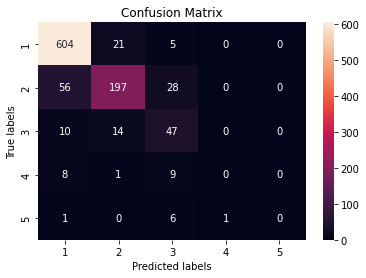

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([1,2,3,4,5]); ax.yaxis.set_ticklabels([1,2,3,4,5]);

In [ ]:
from sklearn import metrics
macro_averaged_precision = metrics.precision_score(y_test,output, average = 'macro')
print(f"Macro-averaged Precision score : {macro_averaged_precision}")

Macro-averaged Precision score : 0.4459547701163


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
micro_averaged_precision = metrics.precision_score(y_test, output, average = 'micro')
print(f"Micro-Averaged Precision score using sklearn library : {micro_averaged_precision}")

Micro-Averaged Precision score using sklearn library : 0.8412698412698413


In [ ]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict
roc_auc_dict = roc_auc_score_multiclass(y_test, output)
roc_auc_dict

{0: 0.8801587301587303,
 1: 0.8257745230974071,
 2: 0.805372254873961,
 3: 0.4994949494949495,
 4: 0.5}

In [ ]:
macro_averaged_f1 = metrics.f1_score(y_test, output, average = 'macro')
print(f"Macro-Averaged F1 score using sklearn library : {macro_averaged_f1}")
micro_averaged_f1 = metrics.f1_score(y_test, output, average = 'micro')
print(f"Micro-Averaged F1 score using sklearn library : {micro_averaged_f1}")

Macro-Averaged F1 score using sklearn library : 0.4511287778479686
Micro-Averaged F1 score using sklearn library : 0.8412698412698413


In [ ]:
save_directory = "/saved_model_readability" # change this to your preferred location

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)


('/saved_model_readability/tokenizer_config.json',
 '/saved_model_readability/special_tokens_map.json',
 '/saved_model_readability/vocab.txt',
 '/saved_model_readability/added_tokens.json',
 '/saved_model_readability/tokenizer.json')